In [83]:
import numpy as np
import matplotlib.pyplot as plt
import cuqi
from cuqi.model import Model #, LinearModel
from cuqi.geometry import MappedGeometry, Continuous1D, KLExpansion #, Geometry, Continuous
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.sampler import MH, NUTS
from scipy.linalg import lu_factor, lu_solve

from beam_model_1D import BeamModel1D

from plot_settings import define_plot_settings

define_plot_settings(18)

np.random.seed(10)

# 1D Beam thickness estimation

<img src="./figures/448603900_1013404393461142_1134514519153019174_n.jpg" width="1000">

The Bayesian inverse problem is to infer the beam thicknesses, $\mathbf{t}$, along the beam from measurements of the beam deflections, $\mathbf{u}$. This can be formulated as

$$ \mathbf{v} = G(\mathbf{t}) + \epsilon $$

where the forward model found by solving the finite element equations:

$$ G(\mathbf{t}) = \mathbf{K}(\mathbf{t})^{-1} \mathbf{f} $$

To represent the thickness as a continuous random function, the KL expansion is introduced as:

$$ \mathbf{X} = \mu_t + \sigma \sum_{i=1}^{N_{KL}} Z_i \sqrt{\lambda_i} \mathbf{e}_i $$

where the thickness can be extracted as $\mathbf{t} = \exp({\mathbf{X}})$ to avoid negative thicknesses.

This transforms the Bayesian inverse problem to instead being a problem of inferring the coefficients, $Z_i$, i.e.

$$ \mathbf{v} = G(\mathbf{t}(Z_i)) + \epsilon $$


The noise is assummed Gaussian

$$ \epsilon \sim \mathcal{N}(0, \sigma_{obs}^2 ) $$

The likelihood function is obtained from the forward model as

$$\pi(v_{obs}|Z_i) \sim \mathcal{N}(G(\mathbf{t}(Z_i), \sigma_{obs}^2 \mathbf{I})$$

Set-up model in CUQI

In [84]:
# Data and initialization
T = lambda x: np.exp(x)             # Define mapping
L = 100                             # Domain length 
N_points = 100                      # Number of discretization points
nelx = N_points - 1                 # No. of beam elements
N_KL = 10                           # Number of terms in KL expansion
grid = np.linspace(0,L,N_points)    # Discretization for domain

# Create 1D beam model
beam = BeamModel1D(nelx=nelx, L=L)
model_Beam = Model(forward=beam.forward, 
                   range_geometry=Continuous1D(grid=grid),
                   domain_geometry=MappedGeometry(KLExpansion(grid=grid,
                                                              num_modes=N_KL),
                                                              map = T))

# Gaussian prior: thkVec -> test it on beam domain (on Zs in KL expansion)
prior = Gaussian(0, 1, geometry=model_Beam.domain_geometry, name='thk')

# Gaussian Likelihood: v
sigma_noise = 5
likelihood = cuqi.distribution.Gaussian(mean=model_Beam, 
                                        cov=sigma_noise**2, 
                                        name='v')
print(model_Beam.range_geometry)
print(model_Beam.domain_geometry)

Continuous1D(100,)
MappedGeometry(KLExpansion(10,))


Create synthetic measurement data. This is acheived by obtaining first computing 'true' signal by sampling from the prior and running forward model. Then, the measurement data is obtained by adding noise to the 'true' signal.

Generate true signal:

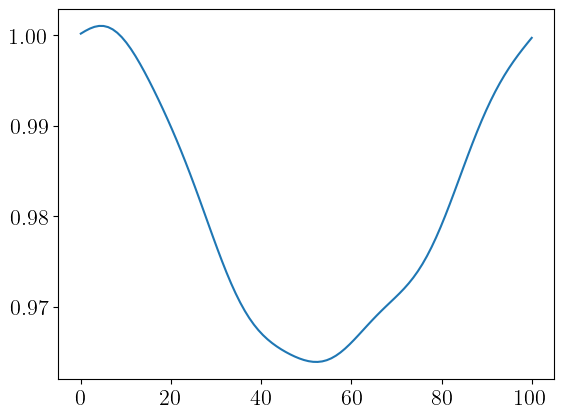

In [94]:
Zs_true = prior.sample(1)
t_true = Zs_true.funvals                # True beam thickness
v_true = beam.forward(t_true)           # True beam deflection

t_true.plot()

Obtain measurement data

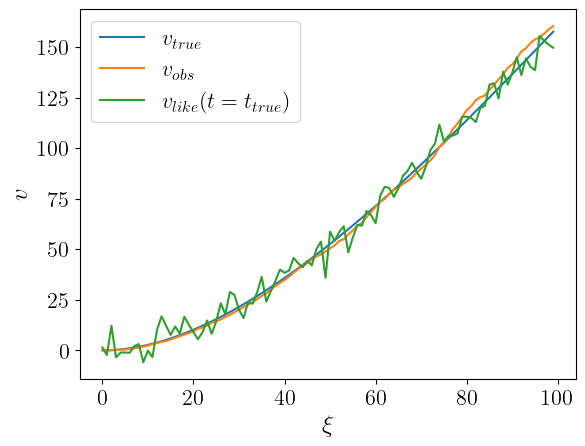

In [86]:
def create_matrix(n):
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i, j] = (1 - abs(i - j) / n)**2
    return matrix
cov = create_matrix(N_points)

# Define noise from noise level
noise_level = 0.5
epsilon = np.random.multivariate_normal(np.zeros(N_points),cov)
epsilon /= np.linalg.norm(epsilon)              # normalize with Euclidean norm
sigma_obs = noise_level*np.sqrt(np.sum(v_true**2*beam.L/N_points))/np.sqrt(N_points) 

# Obtain measurement data by adding noise #TODO: Fix INVERSE CRIME
v_obs = v_true + np.linspace(0,1,N_points)*epsilon*sigma_obs 

# Plot true and measurement data together with likelihood function at t=t_true
plt.plot(v_true, label='$v_{true}$')
plt.plot(v_obs, label='$v_{obs}$')
likelihood(thk=t_true).sample(1).plot(label='$v_{like}(t=t_{true})$')
plt.xlabel('$\\xi$')
plt.ylabel('$v$')
plt.legend()

Define posterior model

In [87]:
joint = JointDistribution(likelihood,prior)
posterior = joint(v=v_obs)
print(posterior)
posterior.geometry

Posterior(
    Equation:
	 p(thk|v) ∝ L(thk|v)p(thk)
    Densities:
	v ~ CUQI Gaussian Likelihood function. Parameters ['thk'].
 	thk ~ CUQI Gaussian.
 )


MappedGeometry(KLExpansion(10,))

Sample using the Metropolis-Hastings sampler

In [96]:
np.random.seed(10)
Ns = 1000
Z0 = Zs_true #np.ones(10)
sampler_MH = MH(posterior, x0=Z0, scale=0.2)
samples_MH = sampler_MH.sample(Ns)

/home/mtaho/miniconda3/envs/cuqitest/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Sample 1000 / 1000

Average acceptance rate: 0.272 



Sample using the No-U-turn sampler (NUTS)

In [89]:
# NUTS Sampler
# Ns = 100
# posterior.enable_FD()
# sampler_NUTS = NUTS(posterior, x0=Zs_true)
# samples_NUTS = sampler_NUTS.sample(Ns,Nb=10)

Compute effective sample sizes

In [90]:
print(samples_MH.compute_ess())
# print(samples_NUTS.compute_ess())

[ 9.47667572  2.64690464  1.35471459  2.59374521  5.10583597  5.21301072
  1.31616867 11.79217661  2.32321637  1.98571799]


Plot credible intervals

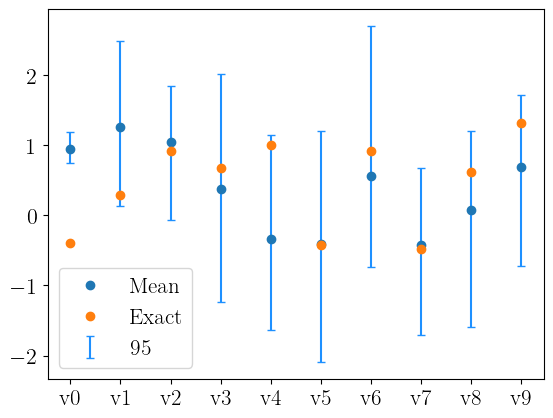

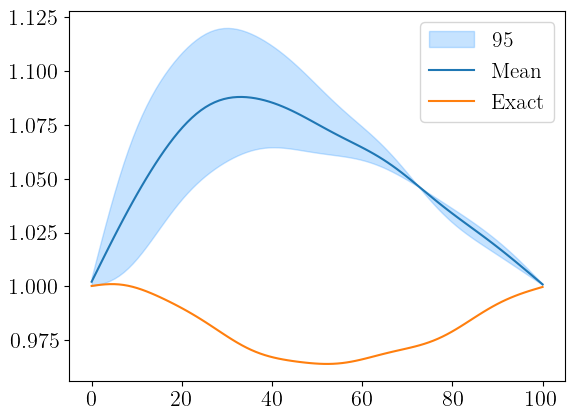

In [97]:
samples_MH.plot_ci(plot_par=True, exact=Zs_true)
#samples_NUTS.plot_ci(plot_par=True,exact=Zs_true)

plt.figure()
samples_MH.plot_ci(plot_par=False, exact=t_true);
#samples_NUTS.plot_ci(plot_par=False,exact=Zs_true)

Plot trace for a specific variable

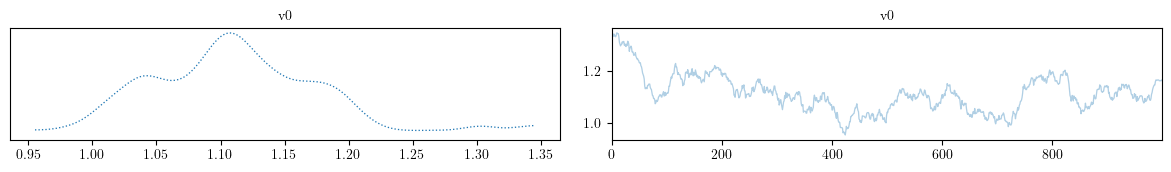

In [92]:
# define_plot_settings(10)
samples_MH.plot_trace([0]);

### Analytical model:

The relation between the beam deflection, $u$, and the external forces is given by the Euler-Bernoulli beam equation:

$$ M(x) = -EI(x) \frac{d^2 v(x)}{d x^2}  $$

The bending stiffness of the beam is a product of the Young's modulus of the material, $E$, and the second moment of area, $I$. The second moment of area of a rectangular beam is related to the beam thickness by

$$ I = \frac{1}{12}bt^3 $$

The moment distribution for the tip load is found as 

$$ M(x) = -P(L - x) $$

Thus, the beam deflection can be found by solving the beam equation:

$$\frac{d^2 v(x)}{d x^2} =  \frac{P}{EI(x)}(L - x) $$
